# Synthetic dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
import shap

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 16

def plot_contribution(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i),fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
        else:
            c = ax.imshow(b[i].reshape(size, size), cmap=plt.get_cmap('viridis', 36), vmin=vmin, vmax=vmax, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='x', colors=(0,0,0,0))
            ax.tick_params(axis='y', colors=(0,0,0,0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.png', bbox_inches='tight')

## Data generation

In [3]:
size = 50

b0 = np.ones((size, size))
b1 = np.ones((size, size))
b2 = np.ones((size, size))
b3 = np.ones((size, size))
b4 = np.ones((size, size))
noise = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b0[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 15**2))
        b1[i, j] = i / 49 * 6
        b2[i, j] = (i + j) / 49 * 3
        b3[i, j] = (j / 49) * 6
        b4[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 12**2))
        # b4[i, j] = 6 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 6 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))
        noise[i, j] = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

# b3 = np.flip(b2, axis=1).T
# b3 = np.ones(size*size).reshape(-1)*2


In [4]:
# b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = b3.reshape(-1)
b4 = b4.reshape(-1)
noise = noise.reshape(-1)

In [5]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size*size)
X2 = np.random.uniform(-2, 2, size*size)
X3 = np.random.uniform(-2, 2, size*size)
X4 = np.random.uniform(-2, 2, size*size)

X = np.vstack([X1, X2, X3, X4]).T
u = np.array([np.linspace(0,size - 1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size - 1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1]
n = X.shape[0]

In [6]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1), columns=['X1', 'X2', 'X3', 'X4', 'x_coord', 'y_coord'])

In [7]:
X_coords

,X1,X2,X3,X4,x_coord,y_coord
0,0.104114,0.964917,1.011381,1.192011,0.0,0.0
1,0.741269,-0.440030,-0.936705,1.024414,1.0,0.0
2,1.342697,-0.875739,-1.148677,-1.992029,2.0,0.0
3,0.615061,1.082512,-1.266801,-0.424231,3.0,0.0
4,-1.851912,0.026923,-0.659943,1.062233,4.0,0.0
...,...,...,...,...,...,...
2495,-1.798074,-0.779403,0.012337,-1.363451,45.0,49.0
2496,0.239688,-0.666447,0.497581,0.348732,46.0,49.0
2497,-1.719665,-1.038000,-0.700350,1.508266,47.0,49.0
2498,-0.650496,-1.045958,0.776005,1.999300,48.0,49.0


In [8]:
# f0 = b0
f1 = b1 * X_coords.values[:, 0]
f2 = b2 * X_coords.values[:, 1]
f3 = b3 * X_coords.values[:, 2]
f4 = b4 * X_coords.values[:, 3]

In [9]:
y = pd.DataFrame(f1 + f2 + f3 + f4 + noise, columns=['y'])

In [10]:
b = [b1, b2, b3, b4, noise]

In [11]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$\beta_{4}(u, v)$', 'noise']

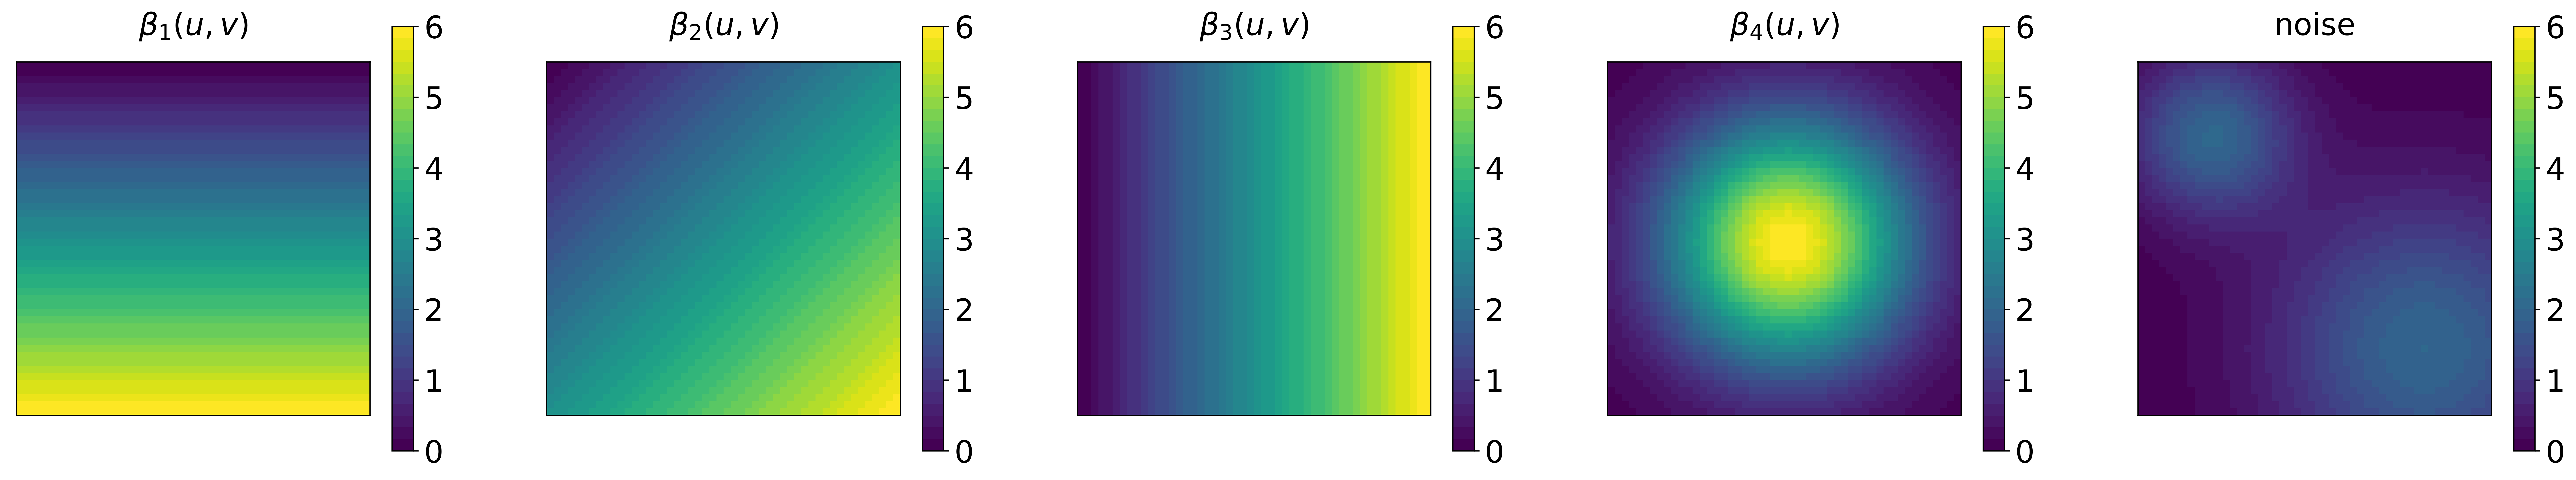

In [14]:
plot_contribution(b=b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation', non_spatial=[])

In [15]:
class Model:
    def __init__(self, f):
        self.predict = f

In [16]:
def predict(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = (v / 49) * 6 * X_coords[i, 2]
        f4 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 3]
        noise = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

        # y = f0 + f1 + f2 + f3 + f4
        y = f1 + f2 + f3 + f4 + noise
        y_pred.append(y)
    return np.array(y_pred)

In [17]:
true_model = Model(predict)

In [18]:
loc = X_coords[['x_coord', 'y_coord']]

In [19]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [20]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5, random_state=42)

In [21]:
X_train, X_calib, loc_train, loc_calib = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [34]:
explainer = GeoConformalizedExplainer(true_model, X_train, X_calib, loc_calib.values, loc.values, 0.1, 25)

In [35]:
results = explainer.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

PermutationExplainer explainer: 2001it [14:05,  2.34it/s]                          
PermutationExplainer explainer: 501it [03:19,  2.39it/s]                         
PermutationExplainer explainer: 2501it [16:39,  2.48it/s]                          
100%|██████████| 6/6 [00:00<00:00, 1862.48it/s]


In [36]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
X1,0.8608,0.988869,0.399649,14.348850,13.689919
X2,1.0000,0.991774,0.336281,13.747011,13.323966
X3,0.0732,0.982695,0.485525,13.622368,13.452422
X4,0.9984,0.997614,0.121531,6.189346,6.449039
x_coord,0.9752,0.960558,0.267716,1.817160,1.774560
y_coord,0.9748,0.937195,0.341209,1.853738,1.744574


In [37]:
pred_results = results.result

In [38]:
results.result_geo

,X1_shap,X2_shap,X3_shap,X4_shap,x_coord_shap,y_coord_shap,X1_value,X2_value,X3_value,X4_value,...,x_coord_pred,y_coord_geo_uncertainty,y_coord_uncertainty,y_coord_upper_bound,y_coord_lower_bound,y_coord_coverage_probability,y_coord_pred,x,y,geometry
0,0.327959,1.543068,1.569732,1.146358,-2.859129,-1.071156,0.104114,0.964917,1.011381,1.192011,...,-2.892983,0.650104,0.721004,-0.718166,-2.018375,0.9748,-1.368270,0.0,0.0,POINT (0.00000 0.00000)
1,1.364726,-0.775769,-1.524737,0.883844,1.534349,-0.965469,0.741269,-0.440030,-0.936705,1.024414,...,1.190793,0.656832,0.721004,-0.608594,-1.922258,0.9748,-1.265426,1.0,0.0,POINT (1.00000 0.00000)
2,2.431695,-1.549666,-1.932346,-1.479013,2.962216,-0.475205,1.342697,-0.875739,-1.148677,-1.992029,...,2.743530,0.656832,0.721004,0.128296,-1.185368,0.9748,-0.528536,2.0,0.0,POINT (2.00000 0.00000)
3,1.210151,1.813279,-2.209046,-0.261491,1.228349,-1.538276,0.615061,1.082512,-1.266801,-0.424231,...,1.035819,0.682841,0.721004,-0.890750,-2.256432,0.9748,-1.573591,3.0,0.0,POINT (3.00000 0.00000)
4,-2.930860,-0.035242,-1.191786,0.992861,0.654882,2.914476,-1.851912,0.026923,-0.659943,1.062233,...,0.399421,0.682841,0.721004,3.214810,1.849128,0.9748,2.531969,4.0,0.0,POINT (4.00000 0.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-7.602610,-3.456032,0.202240,-1.142970,-0.177692,-2.741396,-1.798074,-0.779403,0.012337,-1.363451,...,0.236029,0.744280,0.721004,-1.519969,-3.008528,0.9748,-2.264248,45.0,49.0,POINT (45.00000 49.00000)
2496,1.908121,-2.989731,2.339855,0.367629,0.061019,-0.697478,0.239688,-0.666447,0.497581,0.348732,...,0.414759,0.744280,0.721004,0.516039,-0.972520,0.9748,-0.228241,46.0,49.0,POINT (46.00000 49.00000)
2497,-7.234540,-4.698285,-2.977169,1.325272,-2.163755,-3.909251,-1.719665,-1.038000,-0.700350,1.508266,...,-1.787862,0.744280,0.721004,-2.767944,-4.256503,0.9748,-3.512223,47.0,49.0,POINT (47.00000 49.00000)
2498,-2.240460,-4.790474,3.680552,1.750555,-0.305715,-2.825859,-0.650496,-1.045958,0.776005,1.999300,...,-0.320861,0.744280,0.721004,-1.447776,-2.936335,0.9748,-2.192056,48.0,49.0,POINT (48.00000 49.00000)


In [39]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred', 'x', 'y']]

In [40]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, b['X3_pred'].values, b['X4_pred'].values]

In [41]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$\beta_{4}(u, v)$']

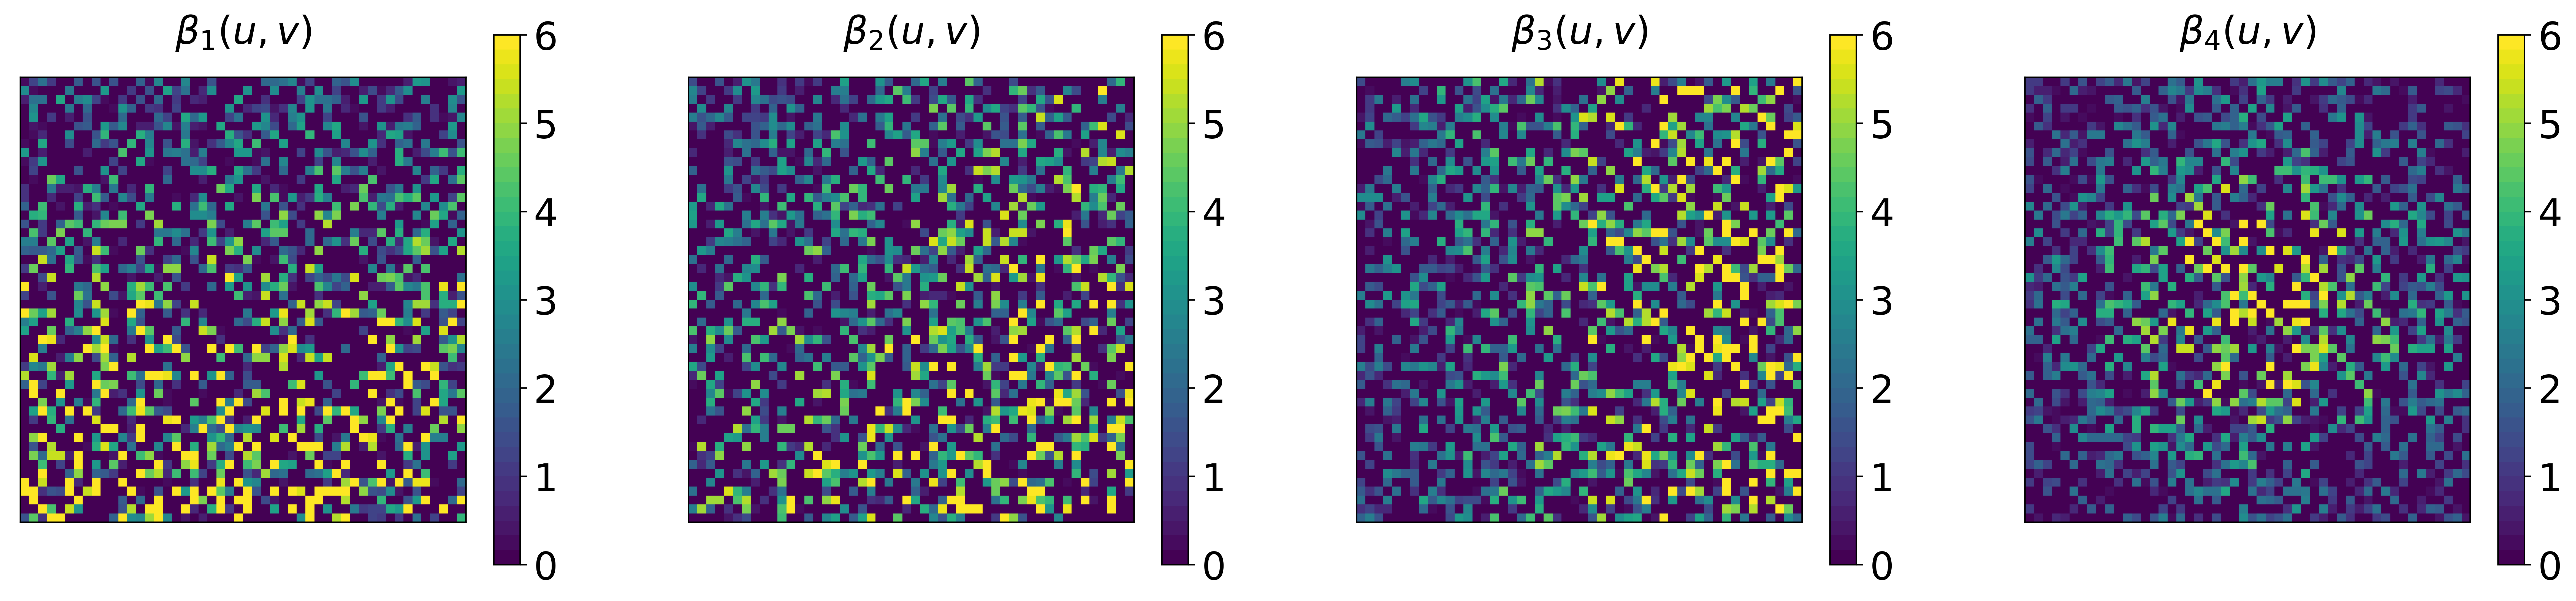

In [42]:
plot_contribution(pred_b, k=4, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[])

In [44]:
plt.rcParams['font.size'] = 16

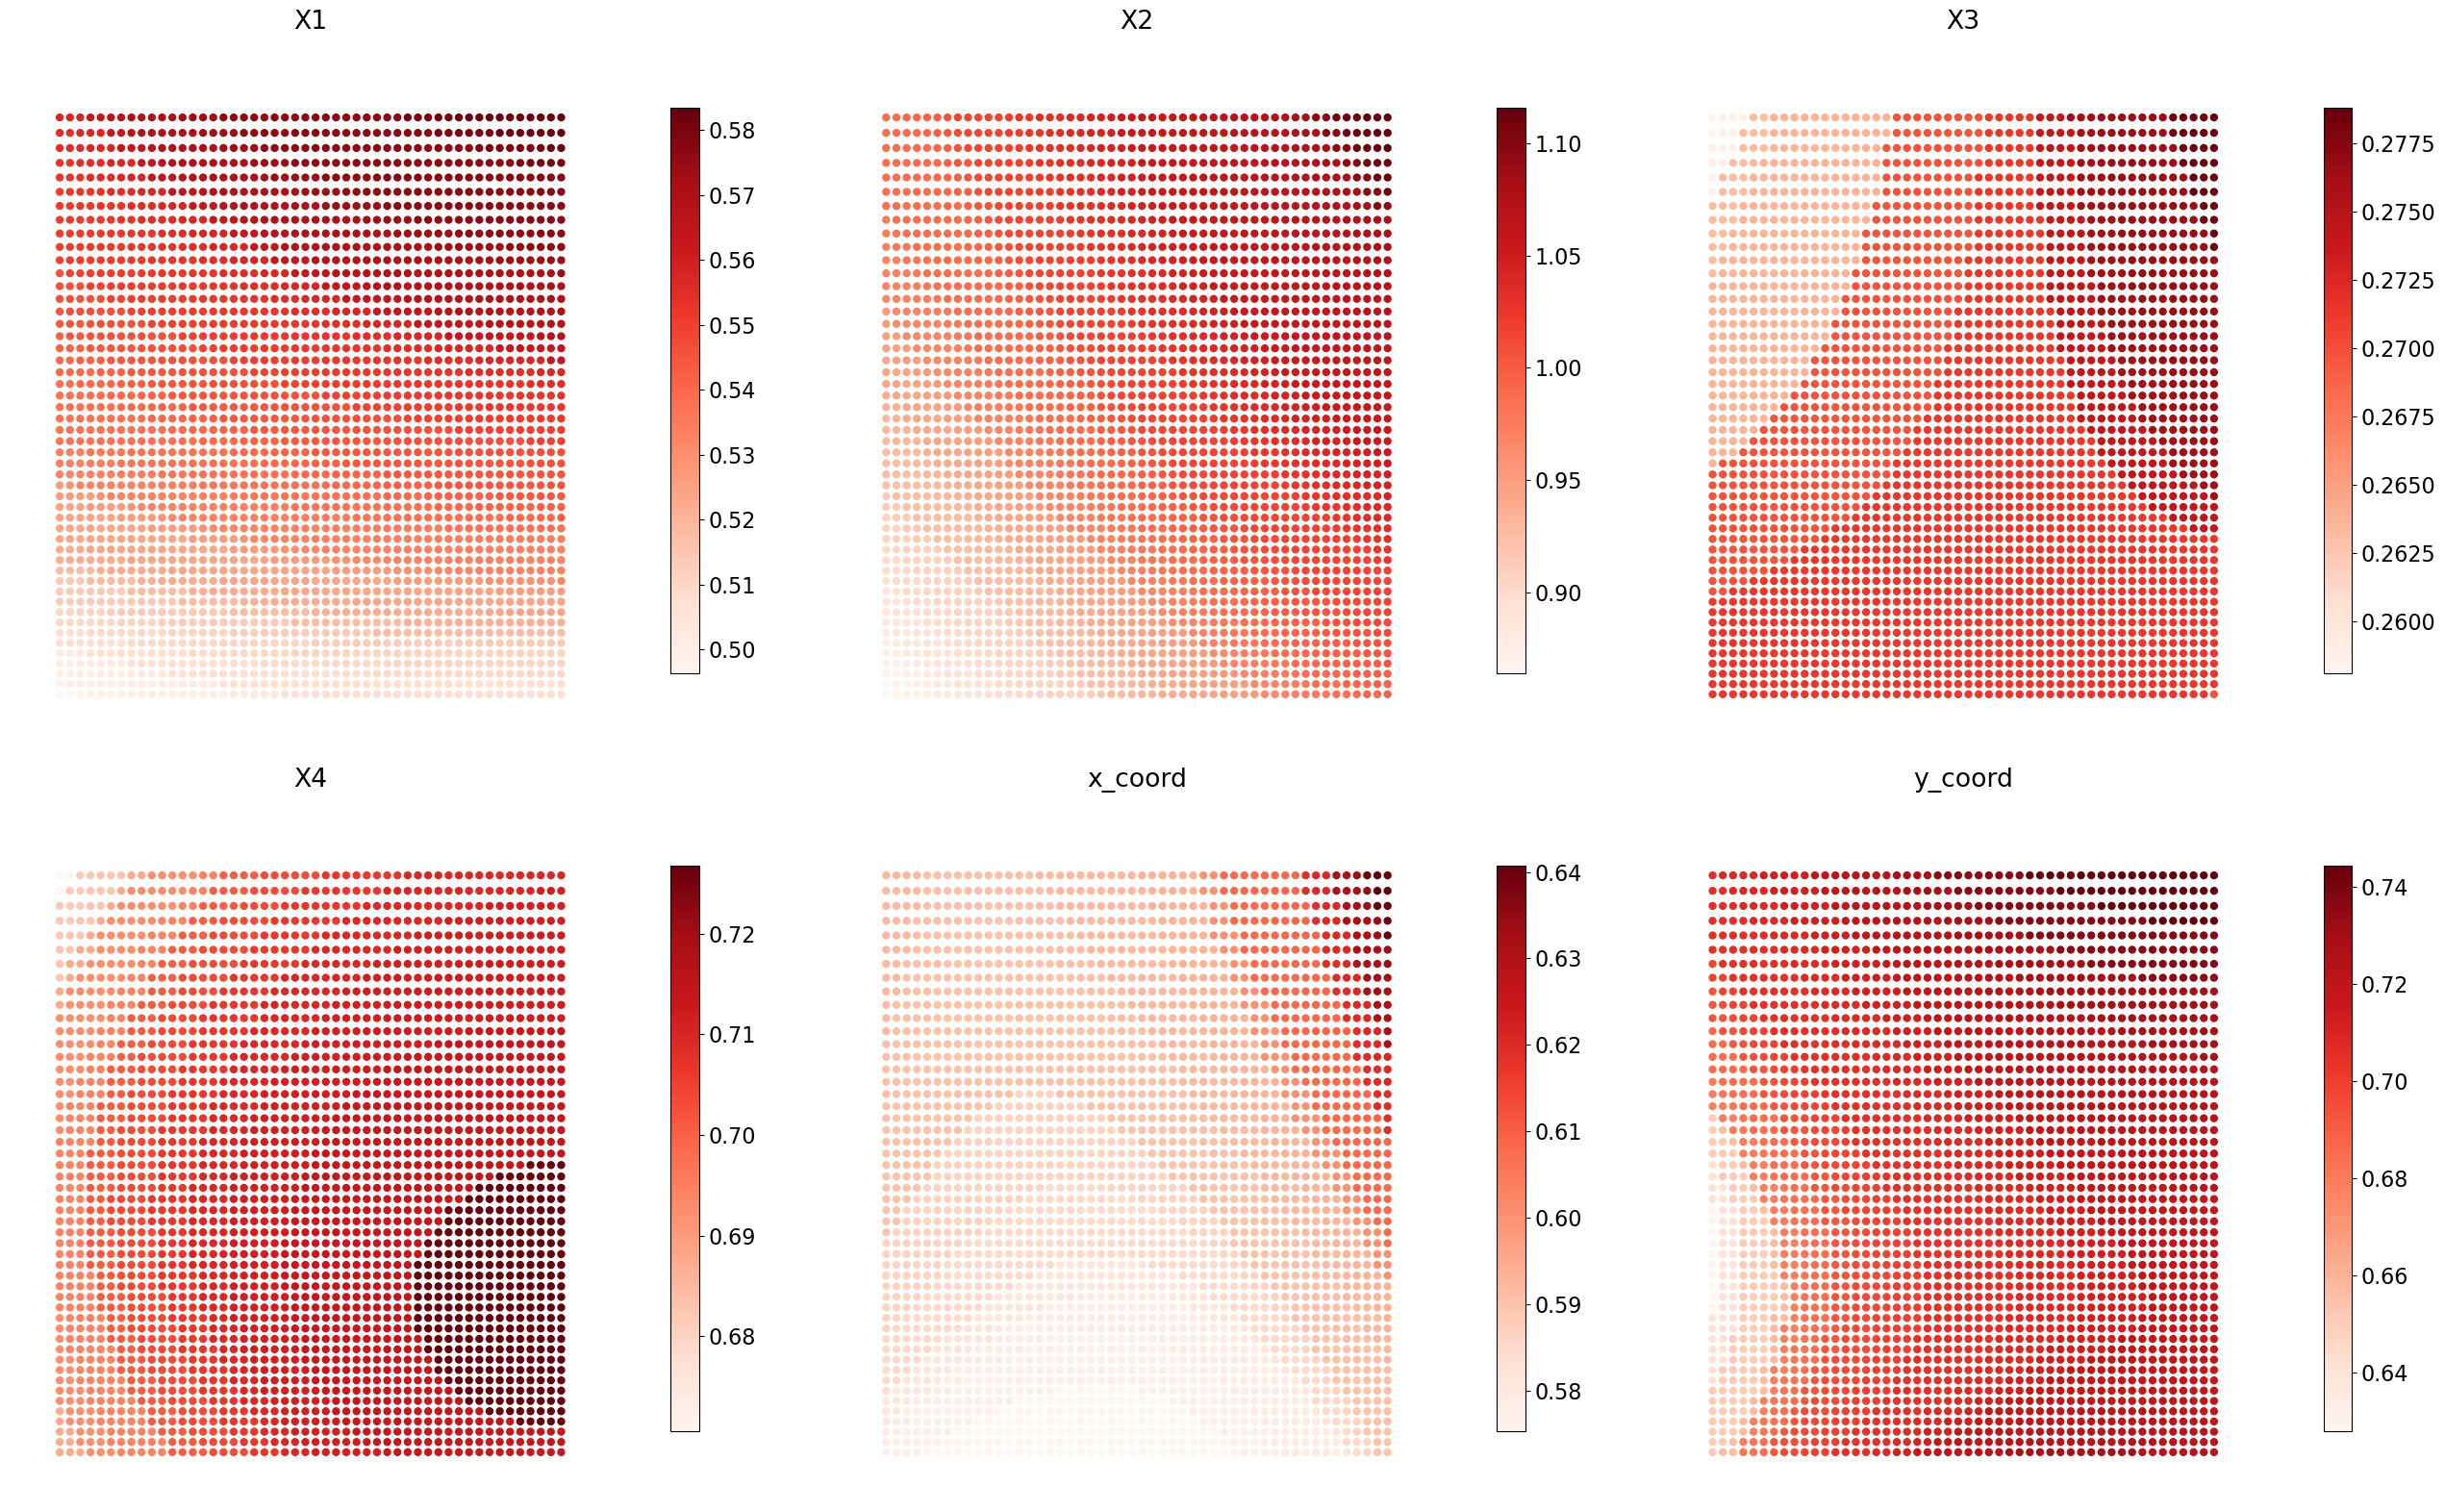

In [45]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [51]:
geo_uncertainty_sum = b1 * pred_results['X1_geo_uncertainty'] + b2 * pred_results['X2_geo_uncertainty'] + b3 * pred_results['X3_geo_uncertainty'] + b4 * pred_results['X4_geo_uncertainty']

In [52]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$']

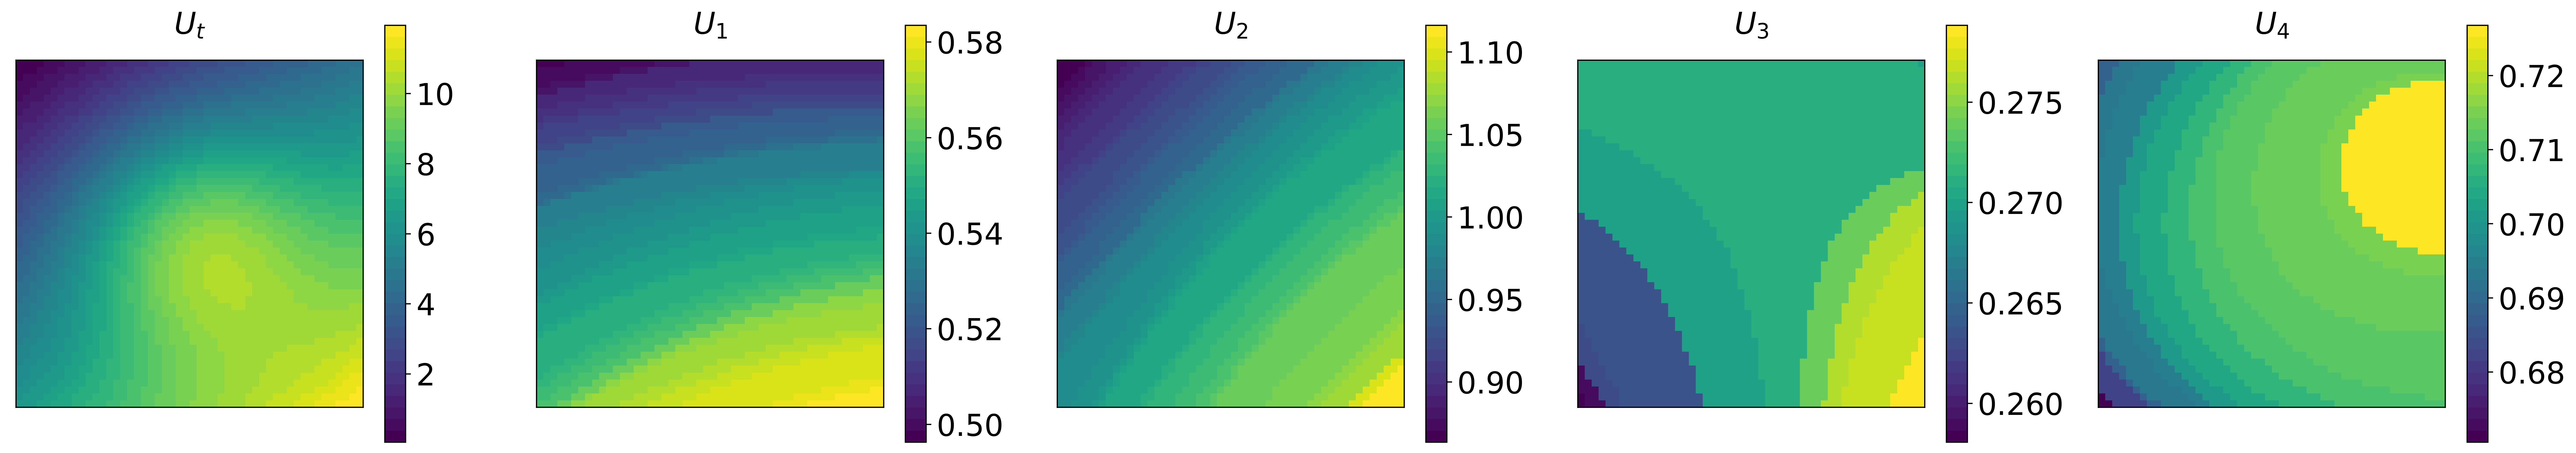

In [53]:
plot_contribution([geo_uncertainty_sum.values, pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values, pred_results['X4_geo_uncertainty'].values], k=5, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])